In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("All libraries imported successfully.")

All libraries imported successfully.


In [3]:
# Load datasets
try:
    train_df = pd.read_csv('train_motion_data.csv')
    test_df = pd.read_csv('test_motion_data.csv')
    print("Train and test data loaded successfully.")
    print(f"Training data shape: {train_df.shape}")
    print(f"Testing data shape: {test_df.shape}\n")
except FileNotFoundError:
    print("Error: Make sure 'train_motion_data.csv' and 'test_motion_data.csv' are in the same directory.")
    exit()

# --- Preprocessing ---

# Drop the Timestamp column
if 'Timestamp' in train_df.columns:
    train_df = train_df.drop('Timestamp', axis=1)
if 'Timestamp' in test_df.columns:
    test_df = test_df.drop('Timestamp', axis=1)

# Check for missing values
print("Missing values in training data:")
print(train_df.isnull().sum())
print("\nMissing values in testing data:")
print(test_df.isnull().sum())
print("\n")

# Define features (X) and target (y)
features = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ']
target = 'Class'

# Separate features and target
X_train = train_df[features]
y_train_labels = train_df[target]
X_test = test_df[features]
y_test_labels = test_df[target]

# Encode target labels (SLOW, NORMAL, AGGRESSIVE) into numbers (0, 1, 2)
le = LabelEncoder()
y_train = le.fit_transform(y_train_labels)
y_test = le.transform(y_test_labels)

# Show the class mapping
print("Class mapping:")
for i, class_name in enumerate(le.classes_):
    print(f"{class_name}: {i}")

Train and test data loaded successfully.
Training data shape: (3644, 8)
Testing data shape: (3084, 8)

Missing values in training data:
AccX     0
AccY     0
AccZ     0
GyroX    0
GyroY    0
GyroZ    0
Class    0
dtype: int64

Missing values in testing data:
AccX     0
AccY     0
AccZ     0
GyroX    0
GyroY    0
GyroZ    0
Class    0
dtype: int64


Class mapping:
AGGRESSIVE: 0
NORMAL: 1
SLOW: 2


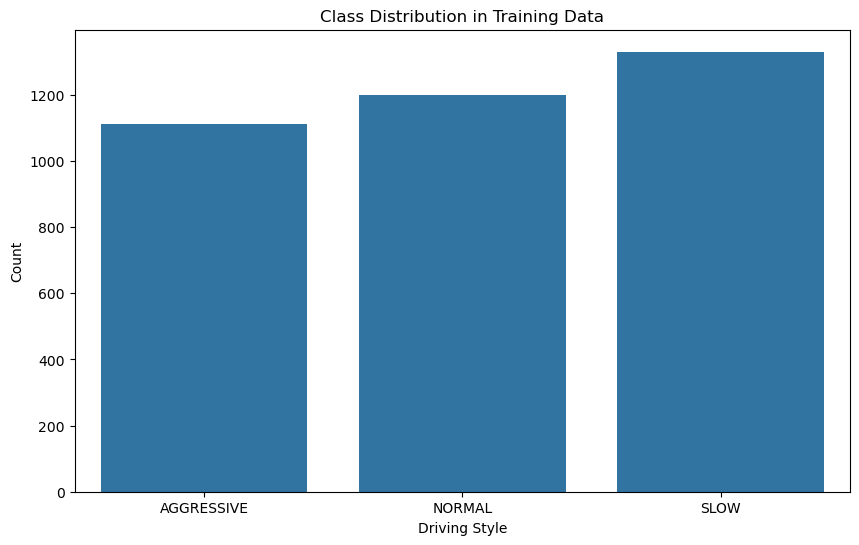

In [4]:
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train_labels, order=le.classes_)
plt.title('Class Distribution in Training Data')
plt.xlabel('Driving Style')
plt.ylabel('Count')
plt.show()

In [5]:
# Define models to train
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'SVM (RBF Kernel)': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Dictionary to store results for comparison
results = {}

print("--- Starting Baseline Model Training & Evaluation ---")

for model_name, model in models.items():
    # Create a pipeline with StandardScaler and the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    # Train the pipeline
    print(f"\nTraining {model_name}...")
    pipeline.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
    
    # Store and print results
    results[model_name] = report['weighted avg']['f1-score']
    print(f"--- Results for {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

print("--- Baseline Evaluation Complete ---")

--- Starting Baseline Model Training & Evaluation ---

Training Logistic Regression...
--- Results for Logistic Regression ---
Accuracy: 0.4504
Classification Report:
              precision    recall  f1-score   support

  AGGRESSIVE       0.45      0.27      0.34       814
      NORMAL       0.36      0.06      0.10       997
        SLOW       0.46      0.88      0.60      1273

    accuracy                           0.45      3084
   macro avg       0.42      0.40      0.34      3084
weighted avg       0.42      0.45      0.37      3084


Training K-Nearest Neighbors...
--- Results for K-Nearest Neighbors ---
Accuracy: 0.3696
Classification Report:
              precision    recall  f1-score   support

  AGGRESSIVE       0.34      0.44      0.38       814
      NORMAL       0.32      0.34      0.33       997
        SLOW       0.45      0.34      0.39      1273

    accuracy                           0.37      3084
   macro avg       0.37      0.38      0.37      3084
weighted avg 

In [6]:
print("\n--- Starting Hyperparameter Tuning for Random Forest ---")

# Create the pipeline
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Define a smaller parameter grid for a quicker search. 
# For a final report, you would use a much larger grid.
param_grid = {
    'model__n_estimators': [100, 200],  # Number of trees
    'model__max_depth': [10, 20],     # Max depth of trees
    'model__min_samples_leaf': [1, 5]     # Min samples in a leaf node
}

# Set up GridSearchCV with 3-fold cross-validation
# We use 'f1_weighted' as the scoring metric due to class imbalance
grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted',
    verbose=2
)

# Fit the grid search on the *training* data
grid_search.fit(X_train, y_train)

print("\n--- Tuning Complete ---")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation F1-score: {grid_search.best_score_:.4f}")

# Store the best model
best_model = grid_search.best_estimator_


--- Starting Hyperparameter Tuning for Random Forest ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=100; total time=   0.1s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=100; total time=   0.1s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=100; total time=   0.1s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=200; total time=   0.2s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=200; total time=   0.2s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=200; total time=   0.2s
[CV] END model__max_depth=10, model__min_samples_leaf=5, model__n_estimators=100; total time=   0.1s
[CV] END model__max_depth=10, model__min_samples_leaf=5, model__n_estimators=100; total time=   0.1s
[CV] END model__max_depth=10, model__min_samples_leaf=5, model__n_estimato


--- Final Evaluation of Tuned Model on Test Data ---
Final Classification Report (Tuned Random Forest):
              precision    recall  f1-score   support

  AGGRESSIVE       0.44      0.42      0.43       814
      NORMAL       0.33      0.26      0.29       997
        SLOW       0.48      0.57      0.52      1273

    accuracy                           0.43      3084
   macro avg       0.42      0.42      0.41      3084
weighted avg       0.42      0.43      0.42      3084



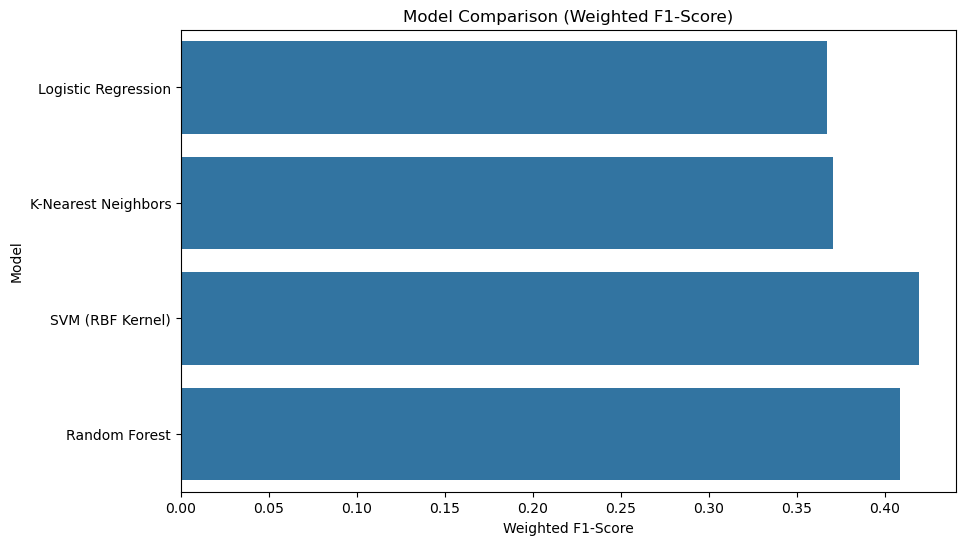

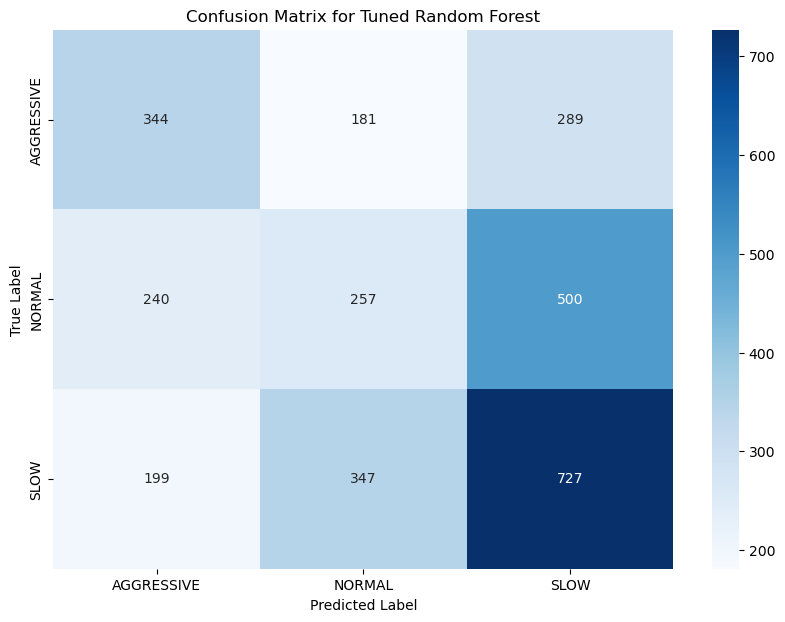

In [7]:
print("\n--- Final Evaluation of Tuned Model on Test Data ---")

# Predict using the best model
y_pred_best = best_model.predict(X_test)

# Print final classification report
print("Final Classification Report (Tuned Random Forest):")
print(classification_report(y_test, y_pred_best, target_names=le.classes_))

# --- Visualization of Results ---

# 1. Compare Model F1-Scores
model_names = list(results.keys())
f1_scores = list(results.values())
f1_scores[model_names.index('Random Forest')] = grid_search.best_score_ # Update with tuned score

plt.figure(figsize=(10, 6))
sns.barplot(x=f1_scores, y=model_names)
plt.title('Model Comparison (Weighted F1-Score)')
plt.xlabel('Weighted F1-Score')
plt.ylabel('Model')
plt.show()

# 2. Confusion Matrix for Best Model
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=le.classes_, 
    yticklabels=le.classes_
)
plt.title('Confusion Matrix for Tuned Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()